In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
url = 'https://github.com/BunayyaIbni/UTS-IOT/blob/main/uts-iot-data-phyphox.xls?raw=true'
acc = pd.read_excel(url, sheet_name='Accelerometer')
gyro = pd.read_excel(url, sheet_name='Gyroscope')


# untuk membaca 5 baris pertama data pada file excel
print(acc.head())
print(gyro.head())

   Time (s)  Acceleration x (m/s^2)  Acceleration y (m/s^2)  \
0  0.029810                2.524686                8.789114   
1  0.031810                2.532168                8.731653   
2  0.033596                2.515109                8.681076   
3  0.035604                2.483984                8.642769   
4  0.037574                2.445677                8.618827   

   Acceleration z (m/s^2)  
0                5.200505  
1                5.104737  
2                4.999393  
3                4.879683  
4                4.752491  
   Time (s)  Gyroscope x (rad/s)  Gyroscope y (rad/s)  Gyroscope z (rad/s)
0  0.065212             1.696184            -0.739738            -1.016299
1  0.067178             1.652509            -0.725357            -0.979016
2  0.069143             1.608302            -0.717368            -0.939602
3  0.071108             1.564628            -0.705118            -0.896993
4  0.073073             1.517757            -0.697661            -0.856514


In [ ]:
# memilih kolom data accelerometer dan gyroscope
acc_cols = ['Time (s)', 'Acceleration x (m/s^2)', 'Acceleration y (m/s^2)', 'Acceleration z (m/s^2)']
gyr_cols = ['Time (s)', 'Gyroscope x (rad/s)', 'Gyroscope y (rad/s)', 'Gyroscope z (rad/s)']
acc_data = acc[acc_cols]
gyr_data = gyro[gyr_cols]


# Mengambil kolom-kolom sumbu X, Y, dan Z dari masing-masing dataframe
accel_x = acc['Acceleration x (m/s^2)']
accel_y = acc['Acceleration y (m/s^2)']
accel_z = acc['Acceleration z (m/s^2)']

gyro_x = gyro['Gyroscope x (rad/s)']
gyro_y = gyro['Gyroscope y (rad/s)']
gyro_z = gyro['Gyroscope z (rad/s)']


# Menghitung gait masing-masing sumbu accelerometer dan gyroscope
gait_accel = np.sqrt(accel_x**2 + accel_y**2 + accel_z**2)
gait_gyro = np.sqrt(gyro_x**2 + gyro_y**2 + gyro_z**2)

print("gait untuk accelerometer")
print(gait_accel)
print()
print("gait untuk gyroscope")
print(gait_gyro)

gait untuk accelerometer
0        10.519877
1        10.426504
2        10.328639
3        10.231272
4        10.141582
           ...    
30127    10.987693
30128    10.935055
30129    10.882334
30130    10.829035
30131    10.785459
Length: 30132, dtype: float64

gait untuk gyroscope
0        2.111188
1        2.053144
2        1.996022
3        1.936452
4        1.877214
           ...   
30109    1.315619
30110    1.322757
30111    1.333370
30112    1.344128
30113    1.353982
Length: 30114, dtype: float64


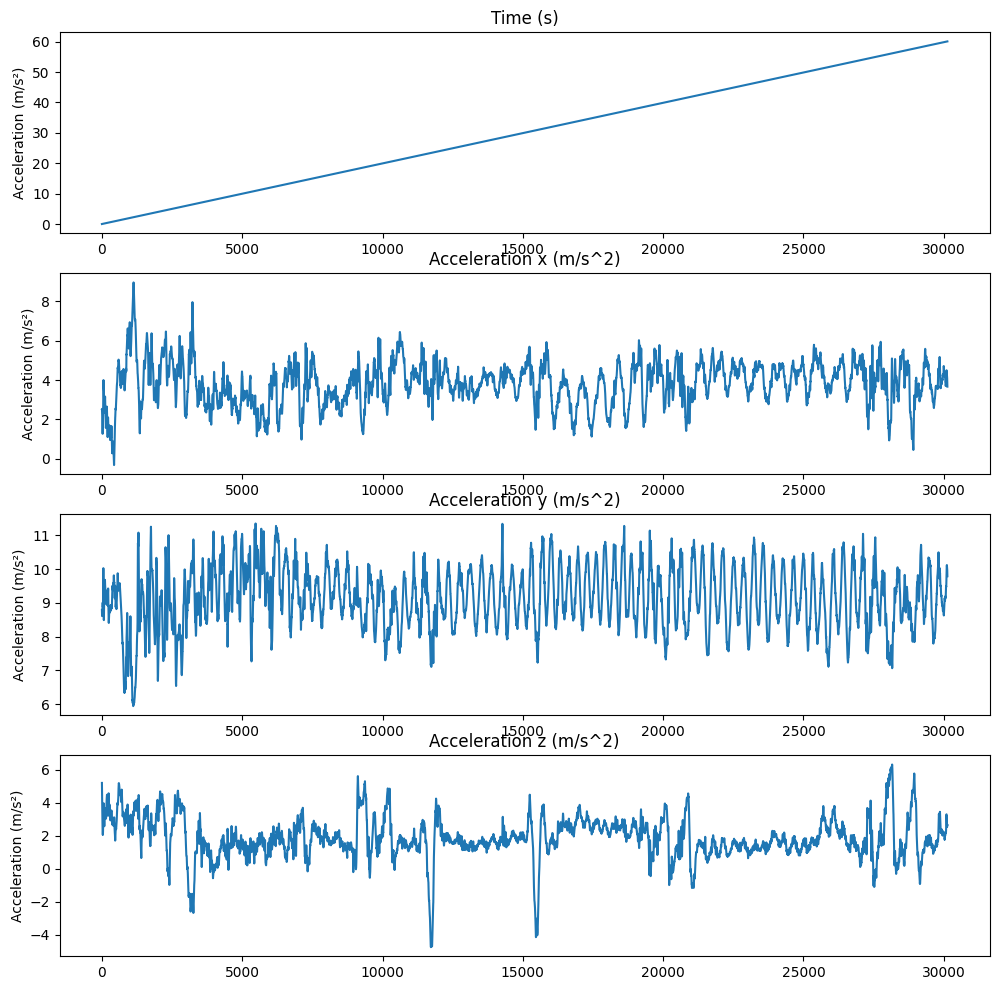

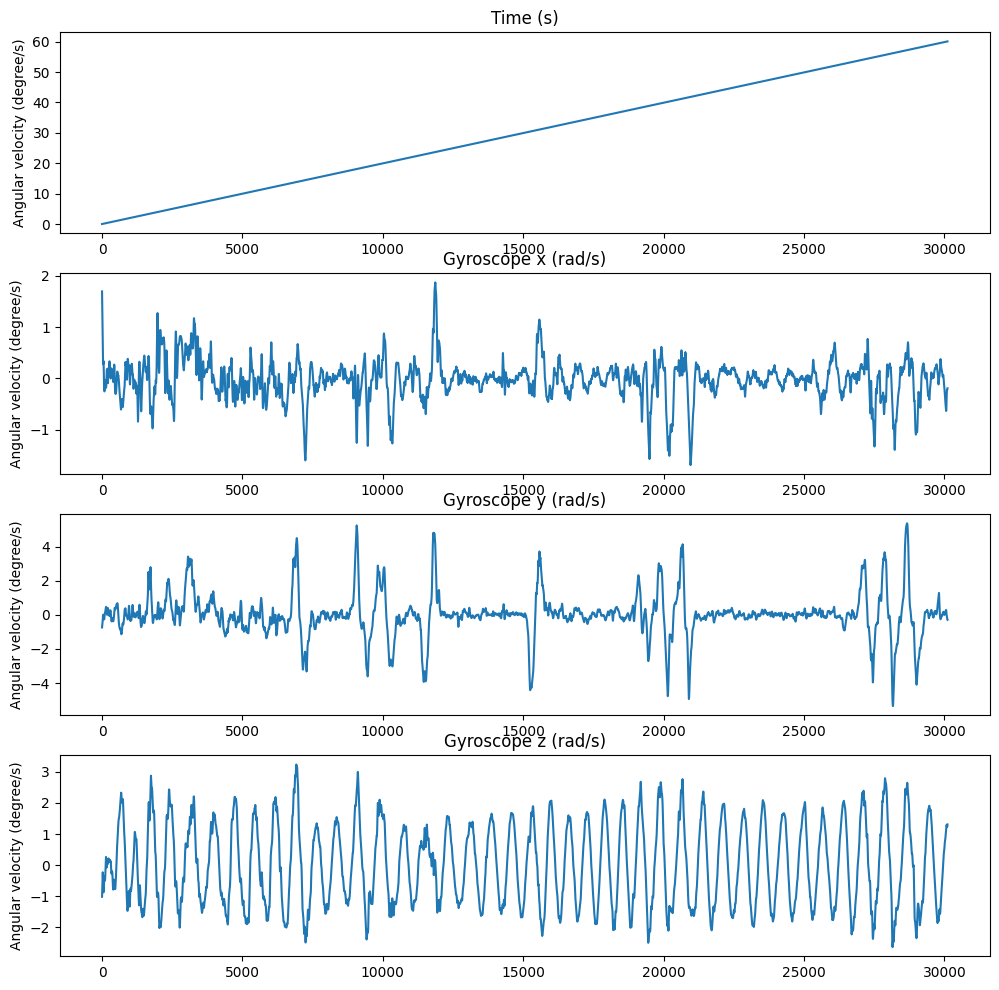

In [ ]:
# membuat plot data accelerometer
fig, axs = plt.subplots(4, 1, figsize=(12, 12))
for i in range(4):
    axs[i].plot(acc_data.iloc[:,i])
    axs[i].set_ylabel('Acceleration (m/s²)')
    axs[i].set_title(acc_cols[i])
plt.show()

# membuat plot data gyroscope
fig, axs = plt.subplots(4, 1, figsize=(12, 12))
for i in range(4):
    axs[i].plot(gyr_data.iloc[:,i])
    axs[i].set_ylabel('Angular velocity (degree/s)')
    axs[i].set_title(gyr_cols[i])
plt.show()

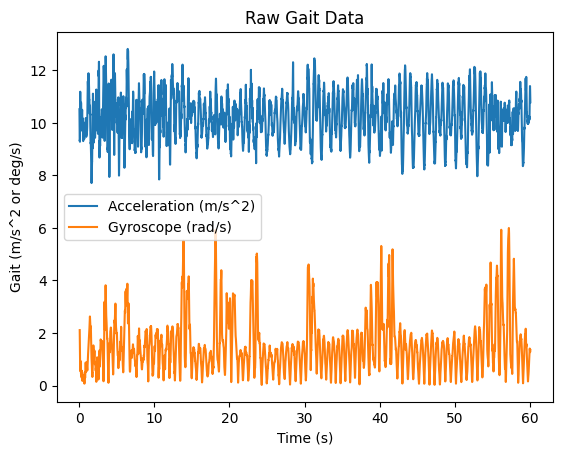

In [ ]:
# Membuat plot untuk data mentah gait accelerometer dan gyroscope
time1 = acc['Time (s)']
time2 = gyro['Time (s)']
plt.plot(time1, gait_accel, label='Acceleration (m/s^2)')
plt.plot(time2, gait_gyro, label='Gyroscope (rad/s)')
plt.xlabel('Time (s)')
plt.ylabel('Gait (m/s^2 or deg/s)')
plt.title('Raw Gait Data')
plt.legend()
plt.show()

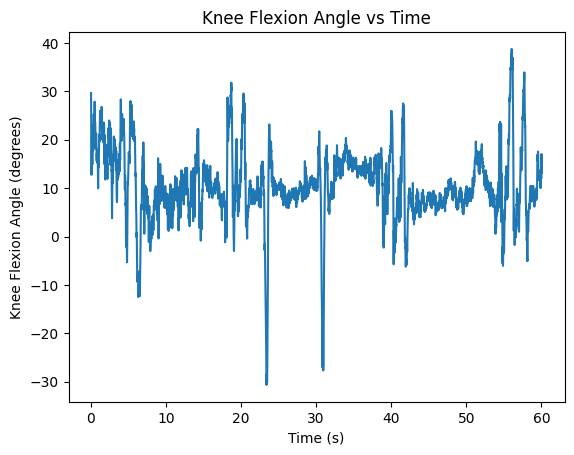

In [ ]:
# menghitung sudut knee flexion
pitch = np.arctan(acc["Acceleration z (m/s^2)"] / np.sqrt(acc["Acceleration y (m/s^2)"]**2 + acc["Acceleration x (m/s^2)"]**2))
knee_flexion = np.degrees(pitch)

# plot sudut knee flexion
fig, ax = plt.subplots()
ax.plot(acc["Time (s)"], knee_flexion)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Knee Flexion Angle (degrees)")
ax.set_title("Knee Flexion Angle vs Time")
plt.show()

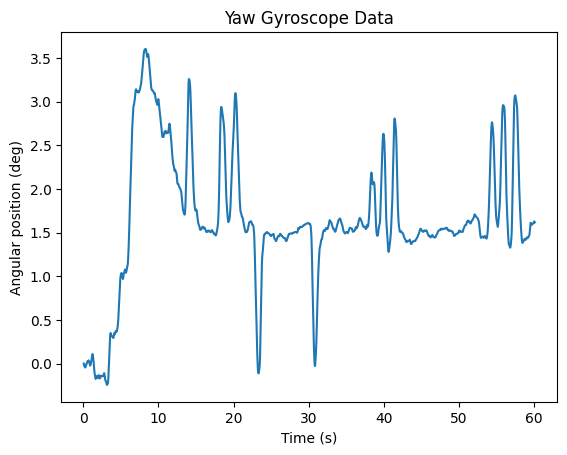

In [ ]:
# mengintegralkan data gyroscope untuk mendapatkan posisi angular(Yaw)
dataTime = np.mean(np.diff(gyro['Time (s)']))

gyro_yaw = np.zeros(len(gyro['Gyroscope x (rad/s)']))
for i in range(1, len(gyro)):
    gyro_yaw[i] = gyro_yaw[i-1] + 0.5 * (gyro['Gyroscope y (rad/s)'][i] + gyro['Gyroscope y (rad/s)'][i-1]) * dataTime

# plot angular position (Yaw)
import matplotlib.pyplot as plt
plt.plot(gyro['Time (s)'], gyro_yaw)
plt.xlabel('Time (s)')
plt.ylabel('Angular position (deg)')
plt.title('Yaw Gyroscope Data')
plt.show()

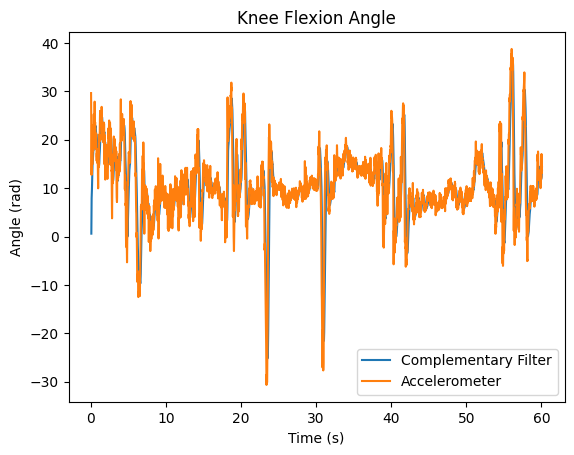

In [ ]:
# mengkonversi kecepatan sudut menjadi perpindahan sudut
dt = np.diff(gyro['Time (s)'])
dt = np.insert(dt, 0, 0)
angle_gyro = np.cumsum(gyro_z * dt)

# Mengatur parameter complementary filter.
alpha = 0.98
angle_cf = np.zeros_like(angle_gyro)

# menerapkan complementary filter
for i in range(len(angle_gyro)):
    angle_cf[i] = alpha * (angle_cf[i-1] + gyro_z[i] * dt[i]) + (1 - alpha) * knee_flexion[i]

# plot knee flexion angle
plt.figure()
plt.plot(time2, angle_cf, label='Complementary Filter')
plt.plot(time1, knee_flexion, label='Accelerometer')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Knee Flexion Angle')
plt.legend()
plt.show()